# Survival analysis: an introduction to model customer churn

Survival analysis is a branch of statistics that analyses the expected duration of time till one or more events will happen. Originating from biomedicine, a lot of studies have focused on time till death / recovery following medical treatment. The method can also be successfully applied to all kinds of industries, to name a few: 
- predicting customer / employee churn for marketing or HR, 
- probability of default modelling for the banking and insurance industry, 
- time till failure for utility maintenance,
- ... .

What all these business questions have in common is that they want to model a censored event, meaning: for some observations we did not observe the event taking place (maybe it will never take place). As a result, these business questions are mostly modelled using a classification approach: a time-window is selected and one classifies whether an event will take place during that time-window or not. 
However, this approach has some down-sides: 
- the criteria to select the time-window are _arbitrarily_, 
- information during this time-window cannot be used as it is part of the target, 
- a complete neglectance of the aspect _time_ till the event takes place. 

Naturally, survival analysis solves the above down-sides by explicitly optimizing an objective function that takes the censoring into account. Then why is it not very well-known? 
One answer may lie in the fact that survival modelling - the relationship between the survival curve and observation characteristics - is quite new. It was only in 1972 that David Cox provided us with a toolset to model the relationship between survival and observation characteristics. 

In this notebook, I provide a genuine introduction to survival analysis in Python. That is, I will for the moment not focus on more advanced methodologies that deal with time-dependent covariates, left truncation nor implement any of the more flexible machine (deep) learning approaches. These may be part of later, upcoming notebooks. 
As a business case, I will attempt to model customer churn at the telecom sector by making use of the publicly available IBM telecom dataset. The dataset has been extensively used as part of the Kaggle datasets and thereby was extensively studies by classification approaches (a good example is https://towardsdatascience.com/predict-customer-churn-with-r-9e62357d47b4).

While I have a lot of experience in survival analysis in R, I am quite new in the Python environment. As such, these notebooks serve to warm-up my coldwater feets as well.

Have a nice read!

## Some basic concepts

Before making our hands dirty with some code, lets first introduce some concepts.
We start by define the probability that an event will take place before time t as the lifetime distribution function: 
$$ F_{t} = Pr(T <= t) $$
If this function has a derivative, we can define the lifetime density function, or the event rate distribution across time as: 
$$ f_{t} = \frac{d F(t)}{dt} $$
Based on the lifetime distribution function, we can define one of the most important descriptive statistics in survival analysis, being the survival function as the complement of the lifetime distribution function. The survival function estimates the probability that one will survive (not witness an event) at time t. 
$$ S_{t} = 1 - F_{t} $$
Last, we can define the hazard function, as the probability that one will observe an event at time t given that no event took place before time t as: 
$$ \lambda_{t} = Pr(T=t| T>t) = \frac{f_{t}}{S_{t}} = -\frac{S_{t}^{'}}{S_{t}} $$

All methodologies related to survival analysis use one of the above concepts as their mean objective to estimate. For example, the Kaplan-Meier survival curve is an estimate of the survival function. Or the Cox Proportional hazards model models the hazard rate as a function of covariates. 


## Setting-up the work environment

In [19]:
import os
import csv
print(os.getcwd())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import lifelines
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
from lifelines import NelsonAalenFitter

%run "helper-functions";

C:\Users\vande70\OneDrive - Cronos 1\Cursussen\Survival Analysis\code


In [20]:
churn = pd.read_csv('..\data\WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID', na_values=[' '])
print(churn.shape)
print(churn.head())
#print(churn.isnull().sum()

(7043, 20)
            gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
customerID                                                                  
7590-VHVEG  Female              0     Yes         No       1           No   
5575-GNVDE    Male              0      No         No      34          Yes   
3668-QPYBK    Male              0      No         No       2          Yes   
7795-CFOCW    Male              0      No         No      45           No   
9237-HQITU  Female              0      No         No       2          Yes   

               MultipleLines InternetService OnlineSecurity OnlineBackup  \
customerID                                                                 
7590-VHVEG  No phone service             DSL             No          Yes   
5575-GNVDE                No             DSL            Yes           No   
3668-QPYBK                No             DSL            Yes          Yes   
7795-CFOCW  No phone service             DSL            Yes          

## Data cleaning

### Correct types

In [21]:
churn[churn.select_dtypes(['object']).columns] = churn.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [22]:
# Set churn as numeric as categorical variables are not admitted by a lot of models
pd.value_counts(churn['Churn'])
churn["Churn"] = np.where(churn['Churn']=='Yes', 1, 0)
print(pd.value_counts(churn['Churn']) / len(churn))

0    0.73463
1    0.26537
Name: Churn, dtype: float64


In [23]:
churn["SeniorCitizen"] = np.where(churn['SeniorCitizen']==1, 'Yes', 'No')
churn["SeniorCitizen"] = churn["SeniorCitizen"].astype('category')
print(pd.value_counts(churn['SeniorCitizen']))

No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64


### Data cleaning

In [24]:
for i in churn.select_dtypes(include='category'):
    print(pd.value_counts(churn[i]))
for i in churn.select_dtypes(include=['int64', 'float']):
    print(churn[i].describe())

Male      3555
Female    3488
Name: gender, dtype: int64
No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64
Yes    6361
No      682
Name: PhoneService, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64
No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64
No                     2810
Yes            

We remove all tenure equal to zero as these cannot be accepted by some models and are quite absurd to use. 

In [25]:
churn = churn[churn['tenure'] > 0]
print(churn[['tenure', 'Churn']].describe())

            tenure        Churn
count  7032.000000  7032.000000
mean     32.421786     0.265785
std      24.545260     0.441782
min       1.000000     0.000000
25%       9.000000     0.000000
50%      29.000000     0.000000
75%      55.000000     1.000000
max      72.000000     1.000000


Now, we move on by inspecting the missings. There seems to be no missings, hence easy peasy go

In [26]:
print(churn.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Final cleaning operation, lets clean-up the content of the categorical variables. Can be usefull for later one-hot-encoding.

In [27]:
for i, colnames in enumerate(churn.select_dtypes(include='category')):
    churn[colnames] = churn[colnames].apply(lambda x: cleaning(x))
print(churn.head())

            gender SeniorCitizen Partner Dependents  tenure PhoneService  \
customerID                                                                 
7590-VHVEG  female            no     yes         no       1           no   
5575-GNVDE    male            no      no         no      34          yes   
3668-QPYBK    male            no      no         no       2          yes   
7795-CFOCW    male            no      no         no      45           no   
9237-HQITU  female            no      no         no       2          yes   

               MultipleLines InternetService OnlineSecurity OnlineBackup  \
customerID                                                                 
7590-VHVEG  no_phone_service             dsl             no          yes   
5575-GNVDE                no             dsl            yes           no   
3668-QPYBK                no             dsl            yes          yes   
7795-CFOCW  no_phone_service             dsl            yes           no   
9237-HQITU 

### Select correct sample (row-wise and column-wise)

Since there are no missings and we filtered allready all observations with tenure equal to zero, we only check some columns. Most importantly to see if there is some multicollinearity. First, lets take a look at the correlations between the continuous variables.

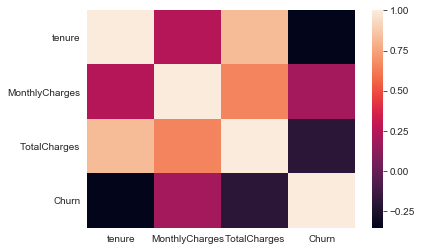

In [28]:
corr_mat = churn.corr()

sns.heatmap(corr_mat, 
            xticklabels=corr_mat.index.values,
            yticklabels=corr_mat.columns.values)
plt.show()

Second, lets take a look at the association between the categorical variables.

In [29]:
print('Cramers V:', cramers_v(cat1='SeniorCitizen', cat2='Contract', data=churn))

Cramers V: 0.1421771426428549


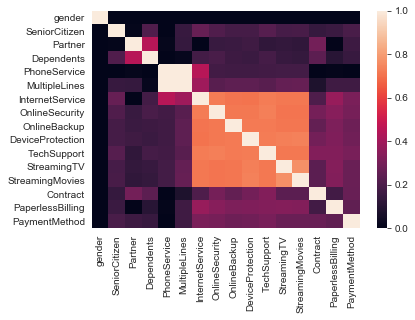

In [30]:
cat = churn.select_dtypes(include='category').columns
cramersv_mat = pd.DataFrame(index=cat, columns=cat)
cramersv_mat = cramersv_mat.fillna(0) # with 0s rather than NaNs

for i, j in enumerate(cat): 
    for u, v in enumerate(cat):
        cramersv_mat.iloc[i, u] = cramers_v(cat1=j, cat2=v, data=churn)

sns.heatmap(cramersv_mat, 
            xticklabels=cramersv_mat.columns.values,
            yticklabels=cramersv_mat.index.values)
plt.show()
#print(cramersv_mat)

Last, lets take a look at the association between a categorical and continuous variable.

In [31]:
print('Correlation Ratio:', correlation_ratio(cat='SeniorCitizen', cont='MonthlyCharges', data=churn))

Correlation Ratio: 0.04834467680083301


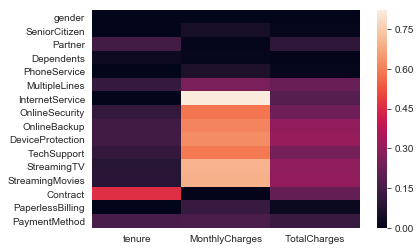

In [32]:
# In matrix
cat = churn.select_dtypes(include='category').columns
cont = churn.select_dtypes(include=['int64', 'float']).columns
corratio_mat = pd.DataFrame(index=cat, columns=cont)
corratio_mat = corratio_mat.fillna(0) # with 0s rather than NaNs

for i, j in enumerate(cat): 
    for u, v in enumerate(cont):
        corratio_mat.iloc[i, u] = correlation_ratio(cat=j, cont=v, data=churn)

sns.heatmap(corratio_mat, 
            xticklabels=corratio_mat.columns.values,
            yticklabels=corratio_mat.index.values)
plt.show()
#print(corratio_mat)

Based on the above analysis, we decide to drop a few variables as they appear to be to highly associated with the other ones. We drop Total Charges rather than Monthly Charges because the former may already include some information on survival (the longer you are a customer, the higher your expected total charges.

In [33]:
to_drop = ['TotalCharges', 'PhoneService']
churn.drop(churn[to_drop], axis=1, inplace=True)

## Describing tenure and churn

First, let's take a look at our target variables of interest. To model customer churn using survival analysis, we need to have two types of information: (1) a time indicator that specifies a duration till last day of observation or any given month of observation and (2) an indicator whether churn was observed or not. In this dataset, we have a variable tenure (in months) that describes the duration till last observation and a variable churn that specifies whether the churn event takes place. First, we need to make some modifications to the data as for some models tenure must be strictly positive (it is also not meaningfull to calculate probability to survive for observations that do not survive at the start) and churn must be labbeled using one-hot encoding.

In [34]:
print(churn['tenure'].describe())
churn.drop(churn[churn.tenure==0].index, axis=0, inplace=True)
print(pd.value_counts(churn['Churn']) / len(churn))
# we recode our outcome variable as being binary (0: no churn, 1: churn)
#churn["Churn"] = np.where(churn['Churn']=='Yes', 1, 0)
print(pd.value_counts(churn['Churn']) / len(churn))

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64
0    0.734215
1    0.265785
Name: Churn, dtype: float64
0    0.734215
1    0.265785
Name: Churn, dtype: float64


We find the average tenure at point of last observation to be 32.3 months. This is an underestimation for the average tenure of clients given that only 26 percent of the clients witnessed churn during the time of observation.
Combining these two pieces, we can create our main descriptive statistics: (1) the survival curve and (2) the hazard curve. 

### Survival curves

Let's start with the survival curve. Suppose we start with a population of 100 persons and we ask, "How many of these 100 persons did not witness the event at any point in time?". The Kaplan-Meier survival function gives an answer to that question by calculating a non-parametric estimate of the percentage of the population that did not witnessed the event / survived (y-axis) by any point in time t (x-axis). Naturally, at time 0, the full population did not witness the event yet. Hence, survival curves starts at 100 percent and monotonically decreases towards 0. Mathematicallyn the KM-curve is the product-sum estimator of the survival rate (d = event rate, n = observations at risk). 
$$ S(t)=\prod_{i=1}^{t-1} (1 - \frac{d_{i}}{n_{i}}) $$ 

0    0.5
dtype: float64


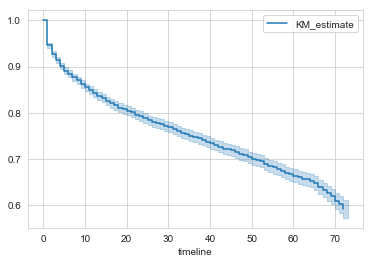

In [35]:
kmf = KaplanMeierFitter()
kmf.fit(churn['tenure'], event_observed=churn['Churn'])
kmf.plot()

Now that we have obtained an estimate of the survival function, we can calculate the median lifetime of the Telecom customers that has been corrected for the fact that some customers did not churn yet during the last point of observation.

In [36]:
kmf.median_

inf

A second estimator of the survival function is the Weibull model. The model assumes survival data comes from a Weibull distribution. An estimate of the Weibull survival function hence estimates the parameters of the Weibull that best describes the data. 

<lifelines.WeibullFitter: fitted with 7032 observations, 5163 censored>
number of subjects = 7032
  number of events = 1869
    log-likelihood = -10576.287

---
         coef  se(coef)  lower 0.95  upper 0.95      p  log(p)     
lambda_  0.00      0.00        0.00        0.00 <0.005 -195.75  ***
rho_     0.64      0.01        0.62        0.67 <0.005    -inf  ***
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1



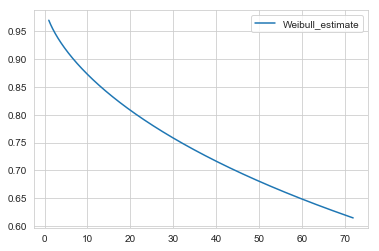

In [37]:
wf = WeibullFitter()
wf.fit(churn['tenure'], churn['Churn'])
wf.print_summary()
wf.survival_function_.plot()

Comparing the Kaplan-Meier and Weibull estimate of the survival curve we find that the latter is smoother due to its parametric form. 
Because the Weibull distribution is determined by only a shape and a scale parameter, it will be more difficult to estimate sudden changes in the survival curve at a given point in time. 
This is observed between time 60 - 70 when the Kaplan-Meier estimates a sudden drop in survival probabilities whereas the Weibull distribution does not. 

A last indirect estimate of survival is provided by the Nelson-Aalen curve. Rather than estimating the survival curve, the Nelson-Aalen estimator calculates the cumulative hazard function. 

          NA_estimate
timeline             
0.0          0.000000
1.0          0.055550
2.0          0.074896
3.0          0.090219
4.0          0.104193


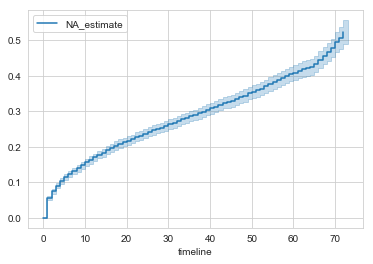

In [38]:
naf = NelsonAalenFitter()
naf.fit(churn['tenure'], event_observed=churn['Churn'])
print(naf.cumulative_hazard_.head())
naf.plot()

### Comparing survival curves?

We can compare differences between two groups in continuous outcomes using student's t-statistic and in categorical outcomes using Pearson's chi square test. Can we compare differences in survival curves using statistical tests? For surelydudelydo! The log-rank test provides such as an estimate. Below, we show an implementation by looking at differences in survival curves between male and females and between contract types.   

In [39]:
from lifelines.statistics import logrank_test
pd.value_counts(churn['gender']) / len(churn)
male = (churn['gender']=='male')

0    0.5
dtype: float64
0    0.5
dtype: float64


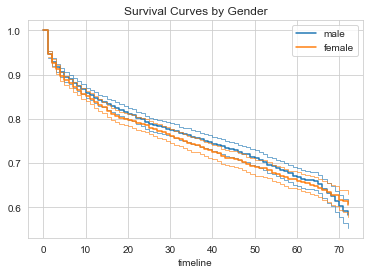

In [40]:
ax = plt.subplot(111)
kmf.fit(churn[male].tenure, event_observed=churn[male].Churn, label="male")
kmf.plot(ax=ax, ci_force_lines=True)
kmf.fit(churn[~male].tenure, event_observed=churn[~male].Churn, label="female")
kmf.plot(ax=ax, ci_force_lines=True)
plt.title("Survival Curves by Gender");

In [41]:
surv_test = logrank_test(churn[male].tenure, churn[~male].tenure, churn[male].Churn, churn[~male].Churn, alpha=0.95)
print(surv_test.print_summary())

<lifelines.StatisticalResult>
               t_0 = -1
             alpha = 0.95
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic    p  log(p)   
          0.53 0.47   -0.76
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1
None


As shown both from the survival curves and the logrank test, there seems to be no difference in survival curves between male and female customers. Now, let's see whether the same applies to customers with a different type of contract.  

In [42]:
from lifelines.statistics import pairwise_logrank_test
pd.value_counts(churn['Contract']) / len(churn)

monthtomonth    0.551052
two_year        0.239619
one_year        0.209329
Name: Contract, dtype: float64

0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64


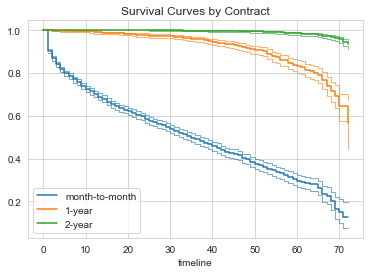

In [43]:
ax = plt.subplot(111)
kmf.fit(churn[churn['Contract']=="monthtomonth"].tenure, event_observed=churn[churn['Contract']=="monthtomonth"].Churn, label="month-to-month")
kmf.plot(ax=ax, ci_force_lines=True)
kmf.fit(churn[churn['Contract']=="one_year"].tenure, event_observed=churn[churn['Contract']=="one_year"].Churn, label="1-year")
kmf.plot(ax=ax, ci_force_lines=True)
kmf.fit(churn[churn['Contract']=="two_year"].tenure, event_observed=churn[churn['Contract']=="two_year"].Churn, label="2-year")
kmf.plot(ax=ax, ci_force_lines=True)
plt.title("Survival Curves by Contract");

In [44]:
surv_test = pairwise_logrank_test(event_durations=churn['tenure'], groups=churn["Contract"], event_observed=churn["Churn"], alpha=0.95, bonferroni=True)
print(surv_test.print_summary())

<lifelines.StatisticalResult>
               t_0 = -1
             alpha = 0.9833333333333333
 null_distribution = chi squared
degrees_of_freedom = 1
    use_bonferroni = True

---
                       test_statistic      p  log(p)     
monthtomonth one_year          926.06 <0.005 -466.67  ***
             two_year         1550.51 <0.005    -inf  ***
one_year     two_year          256.22 <0.005 -131.11  ***
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1
None


Not surprisingly, we do find large differences in survival curves between customers with different contract types. In general, the longer your contract takes, the longer it takes for you to churn. Not suprisingly, Telecom industry sets up a lot of marketing campaigns to push people to take long contracts. 

0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64


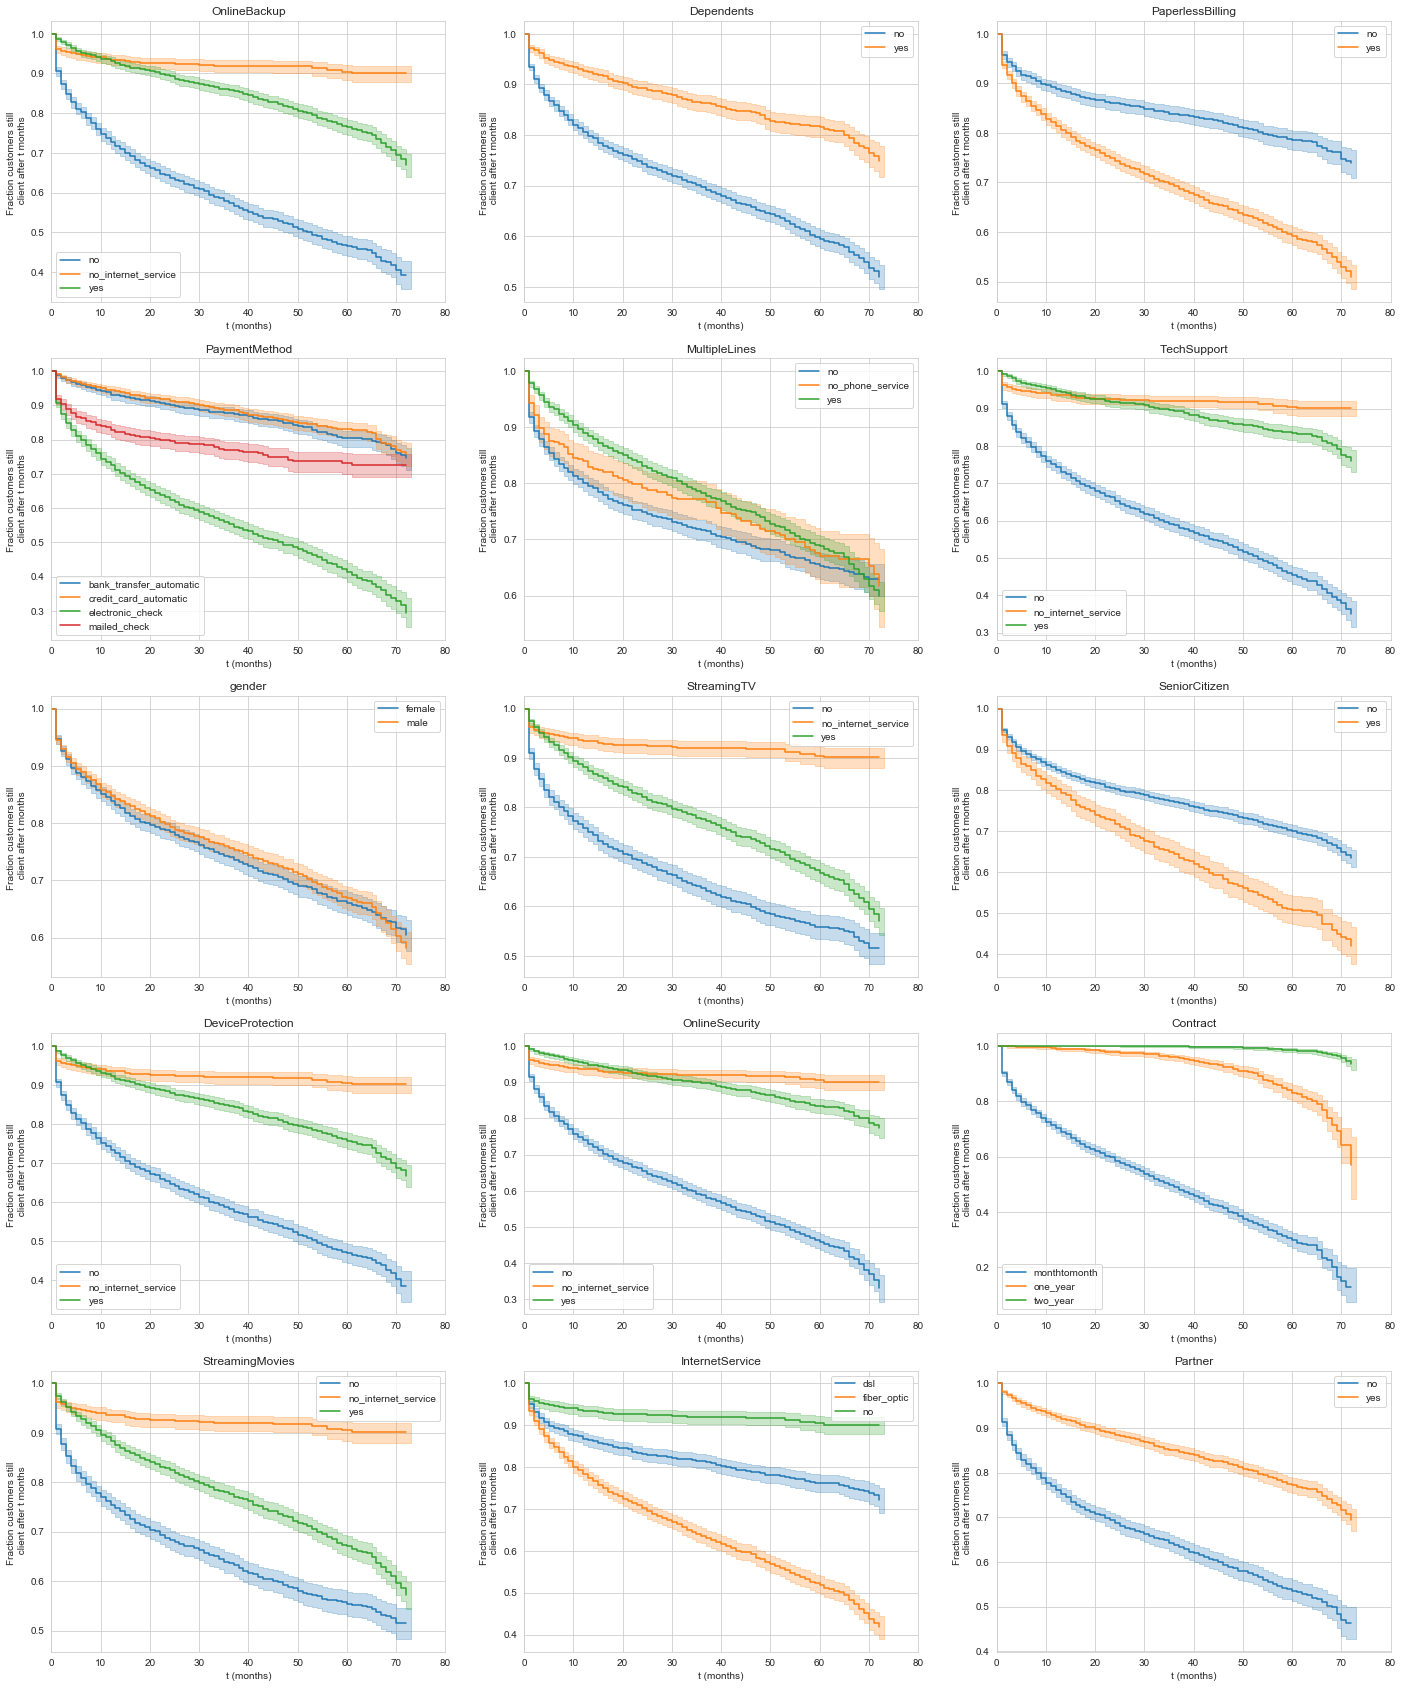

In [45]:
xvars = list(set(churn.select_dtypes(include='category').columns) - set(['tenure', 'Churn']))
fig_rows = np.ceil(len(xvars)/3)
fig_cols = np.ceil(len(xvars)/fig_rows)
plt.figure(figsize=(fig_cols*8, fig_rows*6))

for i, xvar in enumerate(xvars):
    ax = plt.subplot(fig_rows, 3, i+1)
    for name, grouped_df in churn.groupby(xvar):
        kmf.fit(grouped_df['tenure'], grouped_df['Churn'], label=name)
        kmf.plot(ax=ax, legend=True)
        plt.title(xvar)
        plt.xlim(0, 80)
        plt.ylabel('Fraction customers still \n client after t months')
        plt.xlabel('t (months)')

0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64
0    0.5
dtype: float64


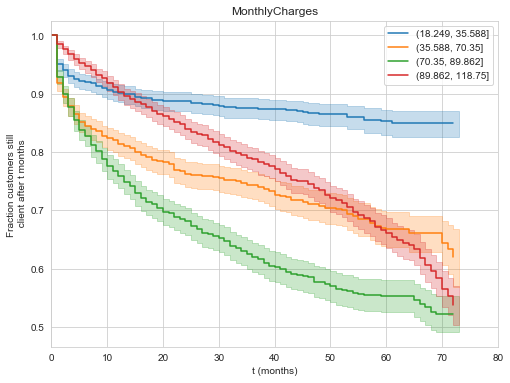

In [46]:
xvars = list(set(churn.select_dtypes(include=['int64', 'float']).columns) - set(['tenure', 'Churn']))
fig_rows = np.ceil(len(xvars)/3)
fig_cols = np.ceil(len(xvars)/fig_rows)
plt.figure(figsize=(fig_cols*8, fig_rows*6))

for i, xvar in enumerate(xvars):
    ax = plt.subplot(fig_rows, fig_cols, i+1)
    churn['xvar_binned'] = pd.qcut(churn[xvar], q = [0, 0.25, 0.5, 0.75, 1])
    for name, grouped_df in churn.groupby('xvar_binned'):
        kmf.fit(grouped_df['tenure'], grouped_df['Churn'], label=name)
        kmf.plot(ax=ax, legend=True)
        plt.title(xvar)
        plt.xlim(0, 80)
        plt.ylabel('Fraction customers still \n client after t months')
        plt.xlabel('t (months)')
    churn.drop('xvar_binned', axis=1, inplace=True)

## Modelling churn

We have described how survival evolves across customers tenure. In addition, we have found statistical differences in survival curves between different customers with different contract types. Now, can we move one step further? Can we model survival in terms of multiple customer characteristics? 

In [47]:
from sksurv.preprocessing import OneHotEncoder
churn_onehot = OneHotEncoder().fit_transform(churn)
churn_onehot.head()

,gender=male,SeniorCitizen=yes,Partner=yes,Dependents=yes,tenure,MultipleLines=no_phone_service,MultipleLines=yes,InternetService=fiber_optic,InternetService=no,OnlineSecurity=no_internet_service,...,StreamingMovies=no_internet_service,StreamingMovies=yes,Contract=one_year,Contract=two_year,PaperlessBilling=yes,PaymentMethod=credit_card_automatic,PaymentMethod=electronic_check,PaymentMethod=mailed_check,MonthlyCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0.0,0.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,29.85,0
5575-GNVDE,1.0,0.0,0.0,0.0,34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,56.95,0
3668-QPYBK,1.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,53.85,1
7795-CFOCW,1.0,0.0,0.0,0.0,45,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.30,0
9237-HQITU,0.0,0.0,0.0,0.0,2,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,70.70,1


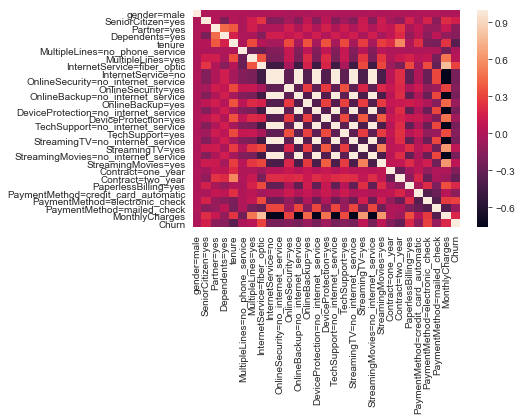

In [48]:
churn_cor = churn_onehot.corr()

sns.heatmap(churn_cor, 
            xticklabels=churn_cor.index.values,
            yticklabels=churn_cor.columns.values)
plt.show()

In [49]:
to_drop = churn_onehot.filter(regex='no_internet_service', axis=1).columns
print(to_drop)
churn_onehot.drop(to_drop, axis=1, inplace=True)

Index(['OnlineSecurity=no_internet_service',
       'OnlineBackup=no_internet_service',
       'DeviceProtection=no_internet_service',
       'TechSupport=no_internet_service', 'StreamingTV=no_internet_service',
       'StreamingMovies=no_internet_service'],
      dtype='object')


### The Cox proportional hazards model

The Cox Proportional Hazards model (Cox PH) - introduced in 1972 - provided a breakthrough in survival analysis. Cox PH models the hazard rate - the probability that an event occurs at time t given that it did not occur before time t - as the exponential of a linear combination of estimated coefficients and characteristics.
$$\lambda(t|X) = \lambda_{0}(t)*e^{(\beta X)}$$

Its main assumption is that the proportional impact of a covariate on the hazard rate is constant over time (hence the name). To see that the proportional impact does not depend on time: 

$$ e^{(\beta)} = \frac{\lambda(t|X=1)}{\lambda(t|X=0)} $$

As a consequence, a coefficient larger than 0 pushes the logarithmic transformation of the hazard curve up (longer conditional duration), whereas a coefficient smaller than 0 pushes the hazard curve down. To see this: 
$$log(\lambda(t|X)) = log(\lambda_{0}(t)) + \beta X$$
The Cox PH model is considered semi-parametric as it does not estimate a baseline hazard (intercept). Hence, one can only discuss impacts in relative terms. It should be noted that, full-parametric proportional hazards models do exist. However, in this case, a specific distribution of the hazard curve needs to be made.


The CoxPHFitter can only take numerical covariates as an input. Hence, we one-hot encode our categorical variables. To not obtain a singular matrix, we remove the baseline categories.


<lifelines.CoxPHFitter: fitted with 7032 observations, 5163 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7032
  number of events = 1869
    log-likelihood = -13884.60
  time fit was run = 2019-01-28 13:46:18 UTC

---
                                     coef  exp(coef)  se(coef)      z      p  log(p)  lower 0.95  upper 0.95     
gender=male                         -0.09       0.92      0.05  -1.84   0.07   -2.72       -0.18        0.01     
SeniorCitizen=yes                   -0.07       0.93      0.06  -1.26   0.21   -1.57       -0.18        0.04     
Partner=yes                         -0.52       0.60      0.06  -9.40 <0.005  -46.65       -0.63       -0.41  ***
Dependents=yes                      -0.05       0.95      0.07  -0.78   0.43   -0.83       -0.19        0.08     
MultipleLines=no_phone_service      -0.25       0.78      0.47  -0.54   0.59   -0.53       -1.18        0.67     
MultipleLines=yes                   -0.42       0.66  

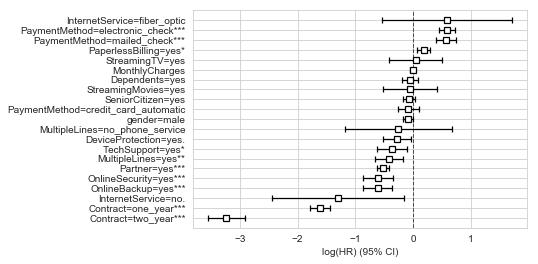

In [50]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(churn_onehot, 'tenure', 'Churn')
print(cph.print_summary())
cph.plot()

From the Cox PH output, we learn that high monthly charges, having a partner, not having internet and contracts for at least one year reduce your hazard rate (and hence decrease customer churn or increase the duration that a customer remains client at the Telecom firm). 
In contrast, using the Phone Service, Fiber Optic internet and paying with electronic and mailed checks increase the hazard rate. 

Let's take a step back before we use the insights learned from our model. First, we need to validate our model. Let's take a look at the goodness-of-fit. The concordance metric provides a way to do so. It measures how much the baseline survival function generated from the Cox PH fit deviates from the Kaplan-Meier survival function. The larger the deviation, the higher the amount of variation that can be explained by the covariates. We find this to be 0.85, so most variation is explained by the covariates. 
Other methods to test goodness-of-fit, spotting for example outliers, can be found by looking at the maringale residuals (not covered here).  

Now, we still need to assess the proportional hazards assumption. This assumption states that the proportional impact of a covariate on the hazard rate is constant over time. The check_assumptions method that is part of the CoxPHFitter provides us will all necessary metrics. Let's take a look. 

0    0.5
dtype: float64

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
                                              test_statistic      p  log(p)     
Contract=one_year                   identity           68.59 <0.005  -36.65  ***
                                    km                 54.31 <0.005  -29.40  ***
                                    log                33.32 <0.005  -18.67  ***
                                    rank               39.68 <0.005  -21.93  ***
Contract=two_year                   identity           39.07 <0.005  -21.62  ***
                                    km                 29.74 <0.005  -16.82  ***
                                    log                13.30 <0.005   -8.23   **
                                    rank               16.92 <0.005  -10.15  ***
Dependents=yes                      identity            0.00   1.00   -0.00     
                            

0    0.5
dtype: float64
5. Variable 'DeviceProtection=yes' failed the non-proportional test, p=0.0410.
   Advice: with so few unique values (only 2), you can try `strata=['DeviceProtection=yes']` in the call in `.fit`. See documentation here: https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
0    0.5
dtype: float64
6. Variable 'TechSupport=yes' failed the non-proportional test, p=0.0039.
   Advice: with so few unique values (only 2), you can try `strata=['TechSupport=yes']` in the call in `.fit`. See documentation here: https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
0    0.5
dtype: float64
7. Variable 'StreamingTV=yes' failed the non-proportional test, p=0.0310.
   Advice: with so few unique values (only 2), you can try `strata=['StreamingTV=yes']` in the call in `.fit`. See documentation here: https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assu

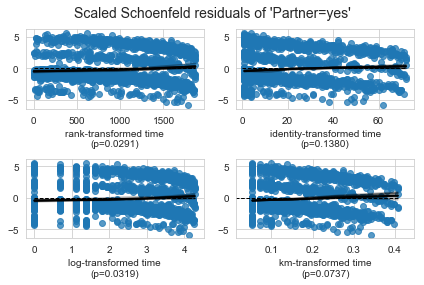

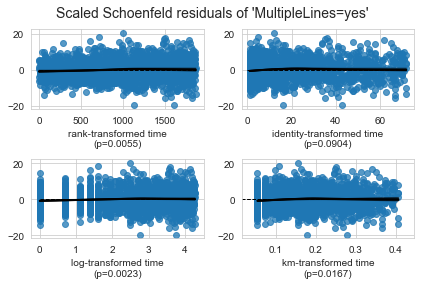

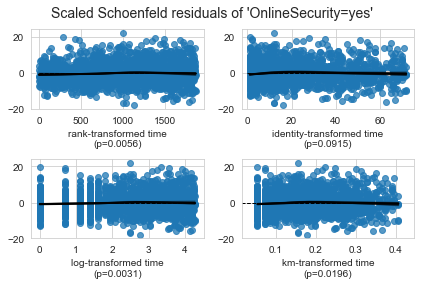

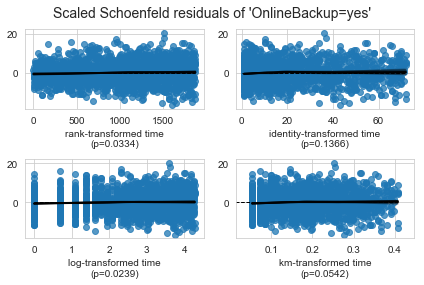

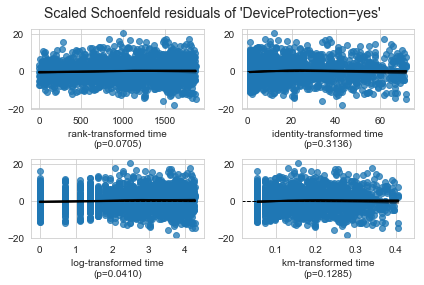

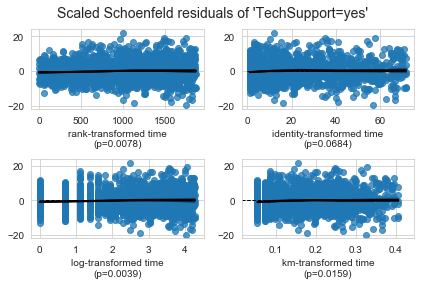

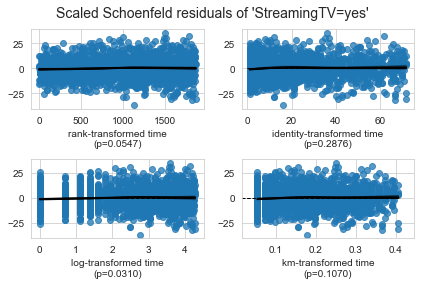

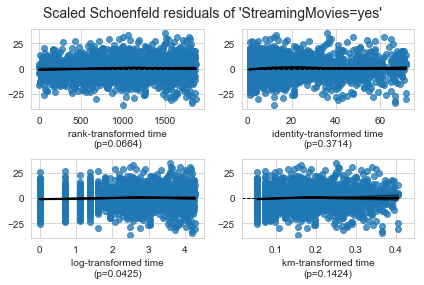

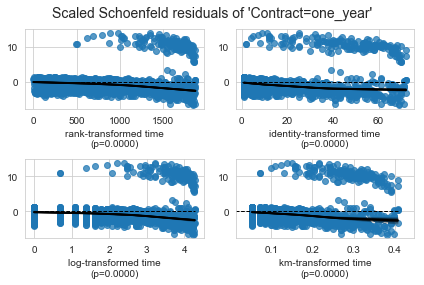

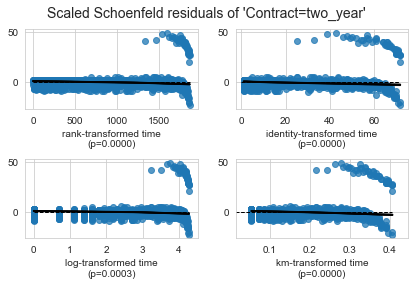

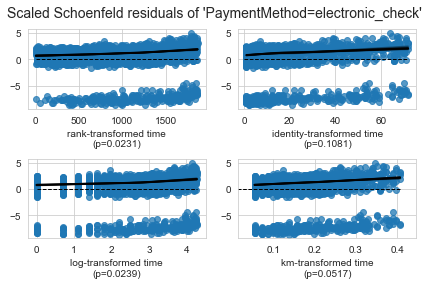

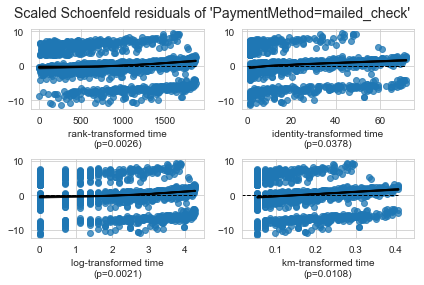

In [51]:
cph.check_assumptions(churn_onehot)

The above output shows us the tests for the PH assumption by looking at the scaled Schoenfeld residuals. Schoenfeld residuals estimate the difference between the covariate for that observation and the weighted average of covariates in the risk set. 
To test the PH assumption, one plots the Schoenfeld residuals against time and observe whether the OLS slope of the residuals on time is equal to zero. Any slope not equal to zero would indicate that the residuals are increasing or decreasing over time and hence the hazard rate would not be constant over time. The SCh

There are several ways to still use the Cox PH model when the Cox PH assumption is validated. First, one could bin the covariates for which the PH assumption is validated and use them as strata. This means they are not modelled as a covariate but that instead every strata has its own baseline hazard. Second, one could usea  time-dependent covariates model and introduce the covariates for which the Cox PH assumption was not met as interactions with a time indicator. 
Here, we will not perform these modifications, instead we will assume that our model is valid to move on to make some model predictions. First, we could predict the partial hazard function as it is assumed that for any observation to be constant over time (Cox PH assumption). 

In [52]:
cph.predict_partial_hazard(churn_onehot).head()

,0
7590-VHVEG,4.483304
5575-GNVDE,0.879299
3668-QPYBK,3.907712
7795-CFOCW,0.300875
9237-HQITU,23.213737


More intuitive, we could predict the survival probability (probability to not churn) at some selected points in time. Here, for every observation, we calculate the probability to not churn after 1, 2, 3, 4 and 5 years. These may be interesting as there complement - the probability to churn before time t - could be used to compare our model predictions with the ones from a traditional classification model. 

In [53]:
cph.predict_survival_function(churn_onehot, times=[12., 24., 36., 48., 60.])

,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK,6713-OKOMC,7892-POOKP,6388-TABGU,...,9767-FFLEM,0639-TSIQW,8456-QDAVC,7750-EYXWZ,2569-WGERO,6840-RESVB,2234-XADUH,4801-JZAZL,8361-LTMKD,3186-AJIEK
12.0,0.776671,0.951640,0.802286,0.983182,0.270189,0.601696,0.829667,0.706446,0.818144,0.980891,...,0.537579,0.924542,0.520259,0.972143,0.993540,0.988019,0.984759,0.786475,0.658626,0.994458
24.0,0.657768,0.921126,0.694112,0.972279,0.114291,0.430851,0.733815,0.562153,0.717000,0.968527,...,0.357454,0.878061,0.338568,0.954252,0.989315,0.980220,0.974865,0.671587,0.500497,0.990831
36.0,0.544548,0.887625,0.588743,0.960031,0.042978,0.294737,0.638228,0.433568,0.617118,0.954661,...,0.224778,0.828053,0.207754,0.934314,0.984534,0.971429,0.963738,0.561226,0.366314,0.986723
48.0,0.405124,0.837601,0.454955,0.941164,0.009293,0.162650,0.512950,0.288699,0.487932,0.933348,...,0.108720,0.755413,0.096708,0.903929,0.977095,0.957823,0.946572,0.423706,0.224708,0.980327
60.0,0.224887,0.746281,0.272372,0.904712,0.000441,0.049825,0.332057,0.128519,0.305739,0.892338,...,0.025618,0.629261,0.021114,0.846368,0.962458,0.931309,0.913313,0.242174,0.084967,0.967720


Last, we can estimate the median survival time. This is the survival time for which the survival probability is equal to 0.5. Given that after our maximal time period of 72 months, the Kaplan-Meier estimate of the survival probability for the entire population still stood at 60 percent, it is very likely that for some observations, the survival probability may not be below 0.5. 

In [54]:
print(cph.predict_median(churn_onehot.head()))

0    0.5
dtype: float64
                  0.5
7590-VHVEG  40.000000
5575-GNVDE  70.000000
3668-QPYBK  44.000000
7795-CFOCW        inf
9237-HQITU   5.000000


### Log-logistic accelerated failure time model

The Cox PH model comes along a very stringent assumption: the effect of a covariate should be proportional and constant over time: this assumption may be violated, as was the case in our study. In addition, the above model involves a linear relationship between the covariates and the hazards function. A positive (negative) coefficient pushes the hazard curve upwards (downwards). Because main descriptive statistics are mostly computed on the survival function, the interpretation of the coefficients is a sometimes a bit hard. 
Full-parametric survival models exist that to obtain the survival estimates that are consistent with a theoretical survival distribution, most commonly: exponential, lognormal, Weibull or log-logistic. Based on these assumptions, a full-parametric linear model is fit to a transformation of the survival curve. Both full-parametric proportional hazards and accelerated failure time (AFT) models exist. The latter models the impact of a covariate by stretching out or contracting survival time. In this particular section, we will experiment with one particular assumed distribution of the survival curve, being that it takes a AFT log-logistic form. To do so, we borrow our example from https://github.com/MustafaOguz/Survival_Analysis/blob/master/4_Parametric_Models.ipynb, which provides AFT and PH models for fully-parametric survival distributions. 

The loglogistic survival model assumes that the loglogistic survival distribution takes the following parametric form. 

$$ S(t)= \frac{1}{1 + \lambda t^{\gamma}} $$

So that, taking the log-logistic transformation of the survival curve is linear related to the parameters. 

$$ -log(\frac{S(t)}{1-S(t)}) = \gamma log(\lambda) + \gamma log(t) $$
Hence, to select the right distributional form, one just needs to plot the assumed transformation (here log-logistic) of the survival curve against the assumed transformation of time (here log) and validate whether a straight line can be drawn between the transformed observations. Let's do this! 



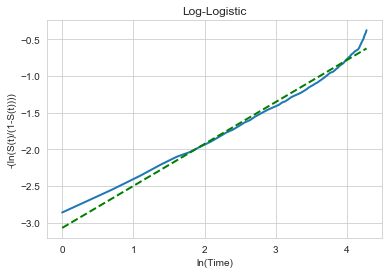

In [57]:
import statsmodels.api as st
from statsmodels.base.model import GenericLikelihoodModel

plt.figure()
# Plotting the transformation of the survival curve to assess goodness of fit. 
plt.plot(np.log(kmf.survival_function_.index.values), -np.log(kmf.survival_function_/(1-kmf.survival_function_)),linewidth = 2.0)
plt.ylabel('Probability of ending')
plt.xlabel('Years')
plt.title('Log-Logistic')
plt.ylabel('-(ln(S(t)/(1-S(t))))')
plt.xlabel('ln(Time)')
y = -np.log(kmf.survival_function_.iloc[1:len(kmf.survival_function_)]/(1-kmf.survival_function_.iloc[1:len(kmf.survival_function_)]))
X = np.log(kmf.survival_function_.index.values[1:len(kmf.survival_function_.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

The log-logistic function seems to capture the Kaplan-Meier estimate of the survival curve quite well. Only at the top there seems to be a small deviation. We have seen that the KM-curve had a sudden drop in survival after 60 months tenure. 

In [16]:
def _ll_loglogisticaft(y,X,beta,gamma):
    scale = np.exp(- np.dot(X,beta) * gamma)
    ll = eventvar * np.log((scale * gamma * np.power(y,gamma - 1))/(1 + scale * np.power(y,gamma))) + np.log(1/(1 + scale * np.power(y,gamma)))    
    return ll

class LoglogisticAFT(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(LoglogisticAFT, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_loglogisticaft(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(LoglogisticAFT, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

In [17]:
timevar = churn_onehot['tenure']
eventvar = churn_onehot['Churn']
survivaldata = churn_onehot[list(set(churn_onehot.columns) - set(['tenure', 'Churn']))]
survivaldata = st.add_constant(survivaldata, prepend=False)
print(survivaldata.columns)

NameError: name 'churn_onehot' is not defined

In [18]:
start_params_var = np.repeat(1, len(survivaldata.columns) + 1)
mod_loglogisticaft = LoglogisticAFT(timevar, survivaldata)
res_loglogAFT = mod_loglogisticaft.fit()
print(res_loglogAFT.summary())

NameError: name 'survivaldata' is not defined

### Aalen's additive model

The Cox PH model comes along a very stringent assumption: the effect of a covariate should be proportional and constant over time. This may not be the case. 
The Aalen's additive model provides an alternative without these assumptions. First, the effects of covariates are allowed to change over time. Second, the effect of a covariate on the hazard rate is additive rather than relative.   
One of the down-sides of Aalen's additive model is that technically, survival probabilities are allowed to increase over time. This offcourse is theoretically impossible. Hence, it is good practice to start with Cox PH, check the assumptions and then compare with Aalen's additive model. 

In [ ]:
from lifelines import AalenAdditiveFitter
aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=False)
aaf.fit(churn_onehot, 'tenure', event_col='Churn')

Having fitted Aalen's additive model, we can use it to estimate the median survival times and survival curves for let's say the first 5 observations. 

In [ ]:
print(aaf.predict_median(churn_onehot).head())
aaf.predict_survival_function(churn_onehot.iloc[0:5,:]).plot();

## Summary

We have come to the end of this small experimentation exercise of survival analysis in Python in which we: 
- introduced the main concepts of survival analysis, 
- provided empirical estimates of the survival curve,
- implemented statistical tests to find differences in survival curves between certain groups, 
- estimated the Cox PH, the log-logistic AFT model and Aalen's additive model, 
- predicted a lot of survival curves and median survival time. 
    
However, the scope of survival analysis is quite extended, hence there are some topics we didn't cover:
- time-varying covariates and left-truncation, 
- machine learning for survival, 
- deep learning for survival. 
  
In the upcoming notebooks, I hope to cover some of the above topics as well!   
   
   
Best,  
Robrecht